In [1]:
%load_ext dotenv
%dotenv 
import os
import sys
sys.path.append(os.getenv('SRC_DIR'))
from logger import get_logger
_logs = get_logger(__name__)

In [2]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import os
from glob import glob

/var/folders/rx/4w4llz_92_j4tgp8r97707280000gn/T/ipykernel_4357/1500862777.py:1: DeprecationWarning: The current Dask DataFrame implementation is deprecated. 
In a future release, Dask DataFrame will use new implementation that
contains several improvements including a logical query planning.
The user-facing DataFrame API will remain unchanged.

The new implementation is already available and can be enabled by
installing the dask-expr library:

    $ pip install dask-expr

and turning the query planning option on:

    >>> import dask
    >>> dask.config.set({'dataframe.query-planning': True})
    >>> import dask.dataframe as dd

API documentation for the new implementation is available at
https://docs.dask.org/en/stable/dask-expr-api.html

Any feedback can be reported on the Dask issue tracker
https://github.com/dask/dask/issues 

  import dask.dataframe as dd


In [8]:
ft_dir = os.getenv("FEATURES_DATA")
ft_glob = glob(ft_dir+'/*.parquet')
df = dd.read_parquet(ft_glob).compute().reset_index()

# Sampling in Python

+ There are different packages that allow sampling.
+ A practical approach is to use pandas/Dask sampling methods.

## Random Sampling

+ Sample n rows from a dataframe with [`df.sample()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html).

```
DataFrame.sample(
    n=None, frac=None, replace=False, weights=None, 
    random_state=None, axis=None, ignore_index=False
    )
```

In [9]:
df.sample(n = 5)

Price,ticker,Date,Adj Close,Close,High,Low,Open,Volume,sector,subsector,year,Close_lag_1,returns,positive_return,target
2426643,EOG,2019-01-07 00:00:00+00:00,73.666756,94.510002,96.410004,92.220001,94.489998,4453100,Energy,Oil & Gas Exploration & Production,2019,93.919998,0.006282,1,1.0
489945,EQIX,2017-06-19 00:00:00+00:00,377.572327,432.220001,432.640015,426.649994,427.859985,457500,Real Estate,Data Center REITs,2017,427.279999,0.011562,1,1.0
2623115,BLDR,2008-03-31 00:00:00+00:00,7.260000,7.260000,7.380000,6.910000,7.000000,117900,Industrials,Building Products,2008,6.960000,0.043103,1,1.0
368424,RHI,2019-04-23 00:00:00+00:00,60.728790,68.790001,69.080002,67.510002,67.959999,2143000,Industrials,Human Resource & Employment Services,2019,67.389999,0.020775,1,0.0
2335857,EMR,2014-03-25 00:00:00+00:00,49.354107,66.349998,66.360001,65.680000,65.730003,4944400,Industrials,Electrical Components & Equipment,2014,65.389999,0.014681,1,0.0


In [10]:
# select_tickers = df['ticker'].unique().tolist()[0:9]
select_tickers = ['OXY', 'TXN', 'PCG', 'CBRE', 'ROK', 'AMT', 'D', 'YUM', 'PWR']
select_tickers

['OXY', 'TXN', 'PCG', 'CBRE', 'ROK', 'AMT', 'D', 'YUM', 'PWR']

In [11]:
idx = df['ticker'].isin(select_tickers)
small_df = df[idx]
simple_sample_dt = small_df.sample(frac = 0.1)
simple_sample_dt.shape, small_df.shape

((5516, 15), (55163, 15))

Look at the distribution of tickers.

<Axes: xlabel='ticker'>

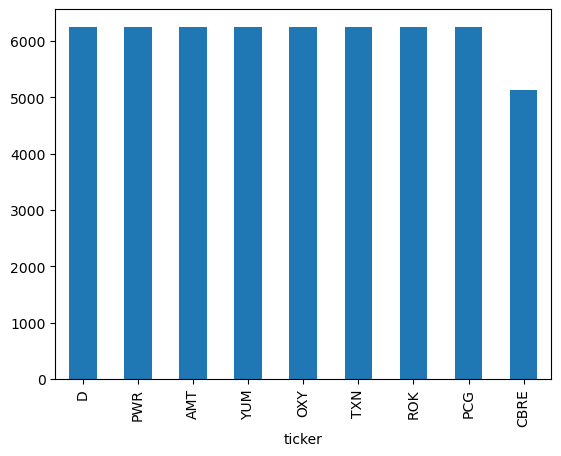

In [12]:
small_df['ticker'].value_counts().plot(kind='bar')

<Axes: xlabel='ticker'>

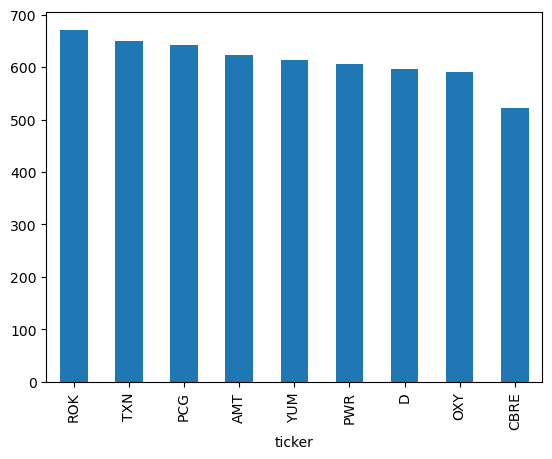

In [13]:
simple_sample_dt['ticker'].value_counts().plot(kind='bar')

## Stratified Sampling

+ Use `groupby()` and `.sample()` for stratified sampling.

<Axes: xlabel='ticker'>

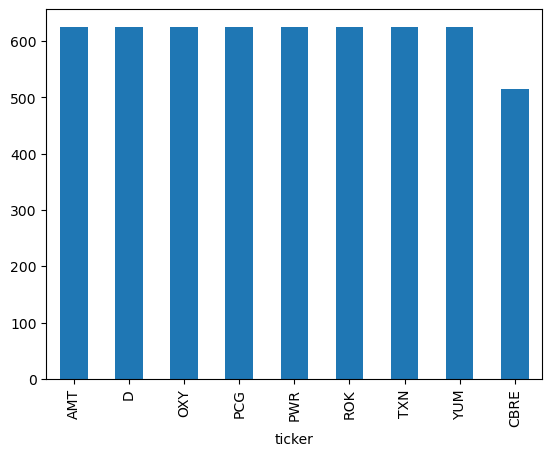

In [14]:
strat_sample_dt = small_df.groupby(['ticker']).sample(frac = 0.1)
strat_sample_dt['ticker'].value_counts().plot(kind='bar')

# Sampling in Dask

+ Stratified sampling in `dask` can be achieved with `groupby().apply()` and a lambda function.

/var/folders/rx/4w4llz_92_j4tgp8r97707280000gn/T/ipykernel_4357/2932236319.py:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  strat_sample_dd_dt = (dd_dt


<Axes: xlabel='ticker'>

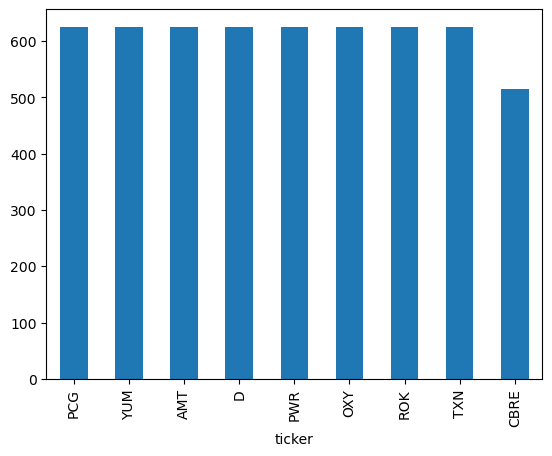

In [15]:
dd_dt = dd.read_parquet(ft_glob)
strat_sample_dd_dt = (dd_dt
                      .groupby('ticker', group_keys=False)
                      .apply(lambda x: x.sample(frac = 0.1))
                      .compute()
                      .reset_index())
strat_sample_dd_dt[strat_sample_dd_dt['ticker'].isin(select_tickers)]['ticker'].value_counts().plot(kind='bar')